In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from segment import Movie


In [4]:
exp_sum = pd.read_csv('/Users/shurlimann/Documents/Garner_lab_projects/ribosomal_fusions/experiment_summary.csv')
microscopy_controls = '/Users/shurlimann/Documents/Garner_lab_projects/Calarco_microscopy_controls'
data_path = '/Users/shurlimann/Documents/Garner_lab_projects/ribosomal_fusions/data/fluorescence'

In [5]:
df = pd.DataFrame()
for i, row in exp_sum.iterrows():
    exp_dir = f'{data_path}/{row["folder_name"]}'
    if not os.path.exists(f'{exp_dir}/expression_data.pkl'):
        nd2_file = [f for f in os.listdir(exp_dir) if f[-4:] == '.nd2'][0]
        movie = Movie(filename = f'{exp_dir}/{nd2_file}',
                      ref_name=f'{microscopy_controls}/{row["ref_img"]}',
                      bkg_name=f'{microscopy_controls}/{row["bkg_img"]}')
        movie.calc_expression()

    exp_i = pd.read_pickle(f'{exp_dir}/expression_data.pkl')
    exp_i['strain'] = row['strain']
    exp_i['media'] = row['media']
    exp_i['folder'] = row['folder_name']
    df = pd.concat([df, exp_i])
df = df.dropna()
df = df.reset_index(drop = True)

In [31]:
df['genotype'] = df.strain.map({'bSKH317' : 'WT',
                                'bSKH325' : 'RodZ(S85E)',
                                'bSKH338' : 'MurAA OE',
                                'bSKH348' : 'PrkC OE'})
df['media'] = df['media'].str.replace(' \+ 1\%', '')
df['condition'] = df.genotype + ' in ' + df.media

df_sum = pd.concat([df.groupby('condition').mean()[['expression', 'doublings per hour']],
                    df.groupby('condition').std()[['expression', 'doublings per hour']]],
                   axis = 1)
df_sum.columns = ['mean expression', 'mean growth rate', 'std expression', 'std growth rate']

/var/folders/1c/jtcylk515p5c26hctjb929th0000gp/T/ipykernel_48486/3599076311.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['media'] = df['media'].str.replace(' \+ 1\%', '')


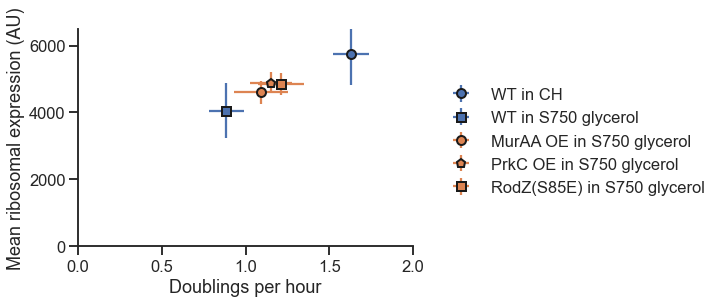

In [33]:

palette = sns.color_palette(n_colors = 2)
sns.set_theme(context = 'talk',
              style = 'ticks')
df_sum['color'] = [palette[0] if 'WT' in i else palette[1] for i in df_sum.index]
df_sum = df_sum.sort_values(by = 'color')
df_sum['markers'] = ['o', 's', 'o', 'p', 's']
fig, ax = plt.subplots(1, 1)
for cond, cond_data in df_sum.iterrows():
    color = cond_data['color']
    plt.errorbar(x = cond_data['mean growth rate'],
                 y = cond_data['mean expression'],
                 xerr = cond_data['std growth rate'],
                 yerr = cond_data['std expression'],
                 marker = cond_data['markers'],
                 color = color,
                 mec = 'k',
                 mew = 2,
                 label = cond,
                 ls = 'none')
ax.set(xlim = (0, 2),
       ylim = (0, 6500),
       xlabel = 'Doublings per hour',
       ylabel = 'Mean ribosomal expression (AU)')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.8),
           frameon = False)
sns.despine(bottom = False, left = False)